# Introduction


---



---



- In this notebook, I perform continuation over alpha_hat. For each alpha_hat, I do a nonlinear mesh solve, based on the analytical Hessian based M.

- Then I do a physical solve (Linear Madden Problem) so that I can compute the error in the physical solution on the resulting mesh.

- I record the L2 error of each solve and pick the `best solve' based on the alpha_hat that led to the physical solution with the lowest L2 error.

#### July 2025

# Results and Conclusions


---



---


- Results are bad - the best mesh is not adapted enough and the physical solution looks bad

- Need to do better at constructing the Hessian Mesh Density function. Need more informative and relaible choices of the scaling on the Hessian in M.



In [ ]:
# install firedrake

# hide output
%%capture

# try:
#     import firedrake
# except ImportError:
#     !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
#     import firedrake


try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [ ]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [ ]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d
from scipy.interpolate import interp1d
import sympy as sp
import scipy as sci


!pip install pympler
from pympler import asizeof



# Setup

In [ ]:
# SETUP
#################################################

# Grid size and epsilon
N = 100
eps = Constant(1e-4)
epsilon = 1e-4


# Set our parameters for the hessian mesh density
# d = 1
p = Constant(2)
q = Constant(2)
m = Constant(0)
exp_M = (2*q) / (1 + q*(2-m))
exp_rho = exp_M/2
RHS = float(2.0)
alpha_hat = Constant(1)



# Initialize uniform mesh for xi
xi_mesh = UnitIntervalMesh(N)
xi_coord = SpatialCoordinate(xi_mesh)[0]


# Our function spaces
V = FunctionSpace(xi_mesh, "CG", 1)
V_phys = FunctionSpace(xi_mesh, "CG", 4)

# Set initial x(xi) to be uniform grid
xi_func = Function(V)
xi_func.interpolate(xi_coord)
perm_x = np.argsort(xi_func.dat.data[:])


# solver parameters
lu_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}

mesh_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'richardson',
    # 'ksp_richardson_scale': 0.5,
    'pc_type': 'lu',
}


newton_params = {
        'snes_type': 'newtonls',
        'snes_monitor': None,
        'ksp_type': 'preonly',
        'snes_linesearch_type': 'basic',
        'snes_linesearch_monitor': None,
        'snes_linesearch_damping': 0.5,
        'pc_type' : 'lu',
        'snes_rtol': 1e-12,
        'snes_stol': 1e-12,
        'snes_max_it': 100,
}

# Create a B Mesh for Comparison

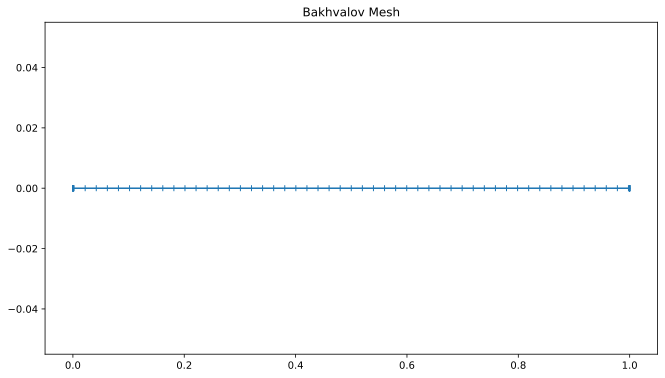

In [ ]:
# Form the 1D B mesh to compare
# NB = 2*N
NB=N
q = 0.25 #roughly 20 points in the layers
sigma = 2.5
b = 1
a = sigma/b
tau = q-a*epsilon
error = 1


while error>1e-14:

  g2 = a*epsilon*(0.5-tau)-(0.5+a*epsilon*np.log(1-tau/q))*(q-tau)
  g2_tau = 1 + a*epsilon*np.log(1-tau/q)
  tau_new =tau-g2/g2_tau
  error = abs(tau-tau_new)
  tau=tau_new


if tau>0:

  phi = -a*epsilon*np.log(1-tau/q)
  phi_tau = a*epsilon/(q-tau)
  x_uni = np.linspace(0, 1, NB+1)
  x_b = np.zeros(NB+1)

  for i in range(1,int(NB/2+1)):
    if x_uni[i]<tau:
      x_b[i] = -a*epsilon*np.log(1-x_uni[i]/q)
    else:
      x_b[i] = -a*epsilon*np.log(1-tau/q)+(x_uni[i]-tau)*phi_tau

  for i in range(int(NB/2+1),NB+1):
    x_b[i] = 1-x_b[NB-i]


else:

  x_b = np.linspace(0, 1, NB+1)


# Plot the result
plt.plot(x_b, [0 for i in range(NB+1)], marker = "|")
plt.title('Bakhvalov Mesh')
plt.show()


Physical Solve:
--------------------------------------------------

  0 SNES Function norm 1.341711474229e-01
  1 SNES Function norm 2.765789248575e-17

Errors in Approximated u:
--------------------------------------------------

L2 error is 1.4025880065547706e-06

The Results:
--------------------------------------------------



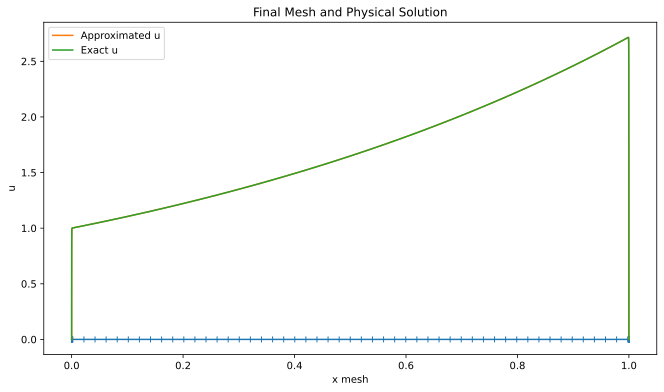

In [ ]:
# Physical Solve and Error on a B Mesh


# SET our B Mesh

bak_func = Function(V)
bak_func.dat.data[perm_x] = x_b[:]


# PHYSICAL SOLVE
#########################################

# Test and Trial Functions
u = TrialFunction(V_phys)
v = TestFunction(V_phys)

# Jacobian of x
Jx = bak_func.dx(0) #dx/dxi


# Set the bilinear and linear forms of the weak form
u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
a = ((eps**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
L = ( exp(bak_func) ) * v * Jx * dx #transform dxi to dx


# Set the BC's
bcs = [DirichletBC(V_phys, Constant(0), 1), DirichletBC(V_phys, Constant(0), 2)]

# Solve
try:
  print()
  print("Physical Solve:")
  print("-"*50)
  print()
  u = Function(V_phys)
  solve( a==L, u, bcs = bcs, solver_parameters = lu_params)
except Exception as e:
  print('The physical solve failed due to the following message:')
  print(e)
  print()




# MEASURING ERRORS
#############################################

print()
print('Errors in Approximated u:')
print("-"*50)
print()
# Reset exact solution (I think this is a waste)
top = (1 - exp(1 - 1/eps))*exp(-bak_func/eps) + (exp(1) - exp(-1/eps))*exp((bak_func-1)/eps)
bottom = (eps**2 - 1) * ( 1 - exp(-2/eps) )
sub = exp(bak_func)/(eps**2 - 1)
u_exact = top/bottom - sub

# L^2 error
error_val = (u - u_exact)
L2_error = norm(error_val * (sqrt(abs(Jx))))
print("L2 error is", L2_error)






# Plot x and u
print()
print('The Results:')
print("-"*50)
print()
plt.plot(bak_func.dat.data[perm_x], np.zeros_like(bak_func.dat.data[perm_x]), marker = "|")
plt.plot(bak_func.dat.data[perm_x], Function(V).interpolate(u).dat.data[perm_x], label = "Approximated u")
plt.plot(bak_func.dat.data[perm_x], Function(V).interpolate(u_exact).dat.data[perm_x], label = "Exact u")
plt.title("Final Mesh and Physical Solution")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()
plt.close()
print()
print()
print()

# Continuation over alpha_hat, analytica H, nonlinear x solve.

In [ ]:
first_alpha_int = 6
last_alpha_int = 1
first_alpha = 10**first_alpha_int
last_alpha = 10**last_alpha_int
alpha_list = np.logspace(first_alpha_int, last_alpha_int, )
alpha_fails = []
alpha_passes = []
L2_errors = []
saved_sols = []

# x and H guesses
######################################

# Define x and H guesses
x_guess = Function(V)
H_guess = Function(V)
x_guess.interpolate(xi_coord)
# x_guess.dat.data[perm_x] = x_b[:]


for alpha_val in alpha_list:

    print()
    print()
    print('For Alpha_Hat = ', alpha_val)
    print('_'*150)
    print()
    print()




    # MESH SOLVE SETUP
    #######################################

    # Lets get our x and H
    x = Function(V)
    vm = TestFunction(V)

    # Guesses
    x.dat.data[:] = x_guess.dat.data[:]


    # Check my guesses (confirm continuation)

    print('Have my guesses updated? (Should match last printed x, H, and u norms)')
    print("-"*50)
    print()
    print('x guess norm =', norm(x_guess))
    print()
    print()


    # ANALYTICAL u''
    ######################################

    # x jacobian
    jacobx = x.dx(0)

    # # Exact u and Hessian
    top = (1 - exp(1 - 1/eps)) * exp(-x/eps) + (exp(1) - exp(-1/eps)) * exp((x - 1)/eps)
    bottom = (eps**2 - 1) * (1 - exp(-2/eps))
    sub = exp(x) / (eps**2 - 1)
    u_f = top / bottom - sub

    upr_f = (1/jacobx) * u_f.dx(0)
    u_pr_xi = u_f.dx(0)
    u_prpr_xi = u_pr_xi.dx(0)
    x_prpr_xi = jacobx.dx(0)
    u_prpr = ( u_prpr_xi -  upr_f * x_prpr_xi) * (( 1/jacobx )**2)




    # MESH SOLVE WEAK FORM
    # ######################################

    # Mesh density function
    alpha_hat = Constant(alpha_val)
    # Defined w.r.t the current x_guess
    alpha_term1 = float(alpha_hat * sqrt(assemble(u_f*u_f * jacobx * dx)))
    M = ( 1 + (1/alpha_term1) * abs(u_prpr) )**exp_M

    # v'
    v_pr_term = (vm).dx(0)

    # the lhs of the eqn
    F_m = (M * jacobx * v_pr_term) * dx

    # bc's
    bc0 = DirichletBC(V, Constant(0), 1)
    bc1 = DirichletBC(V, Constant(1), 2)
    bcs = [bc0, bc1]



    # MESH SOLVE
    ###########################################

    # Solve

    try:
        # Solve combined problem

        print("Mesh Solve:")
        print("-"*50)
        print()
        solve( F_m == 0, x , bcs = bcs, solver_parameters = newton_params)

        # Update the guesses
        x_guess.dat.data[:] = x.dat.data[:]


    except Exception as e:

        print('Mesh solve failed due to the following message:')
        print(e)
        print()
        alpha_fails.append(alpha_val)
        continue

    # If we make it here, our alpha_hat worked!
    alpha_passes.append(alpha_val)



    # PHYSICAL SOLVE
    #########################################

    # Test and Trial Functions
    u = TrialFunction(V_phys)
    v = TestFunction(V_phys)

    # Jacobian of x
    Jx = x.dx(0) #dx/dxi


    # Set the bilinear and linear forms of the weak form
    u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
    v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
    a = ((eps**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
    L = ( exp(x) ) * v * Jx * dx #transform dxi to dx


    # Set the BC's
    bcs = [DirichletBC(V_phys, Constant(0), 1), DirichletBC(V_phys, Constant(0), 2)]

    # Solve
    try:
      print()
      print("Physical Solve:")
      print("-"*50)
      print()
      u = Function(V_phys)
      solve( a==L, u, bcs = bcs, solver_parameters = lu_params)
    except Exception as e:
      print('The physical solve failed due to the following message:')
      print(e)
      print()
      break



    # MEASURING ERRORS
    #############################################

    print()
    print('Errors in Approximated u:')
    print("-"*50)
    print()
    # Reset exact solution (I think this is a waste)
    top = (1 - exp(1 - 1/eps))*exp(-x/eps) + (exp(1) - exp(-1/eps))*exp((x-1)/eps)
    bottom = (eps**2 - 1) * ( 1 - exp(-2/eps) )
    sub = exp(x)/(eps**2 - 1)
    u_exact = top/bottom - sub

    # L^2 error
    error_val = (u - u_exact)
    L2_error = norm(error_val * (sqrt(abs(Jx))))
    print("L2 error is", L2_error)


    # Save it
    u_sol = Function(V_phys)
    x_sol = Function(V)
    u_sol.dat.data[:] = u.dat.data[:]
    x_sol.dat.data[:] = x.dat.data[:]

    L2_errors.append(L2_error)
    saved_sols.append([alpha_val, u_sol, x_sol])

    # Track the size of my results list
    print('The Storage Update:')
    print("-"*50)
    print()
    print(f"Total memory size: {asizeof.asizeof(saved_sols) / 1e6:.2f} MB")
    print()
    print()



    # Plot x and u
    print('The Results:')
    print("-"*50)
    print()
    plt.plot(x.dat.data[perm_x], np.zeros_like(x.dat.data[perm_x]), marker = "|")
    plt.plot(x.dat.data[perm_x], Function(V).interpolate(u).dat.data[perm_x], label = "Approximated u")
    plt.plot(x.dat.data[perm_x], Function(V).interpolate(u_exact).dat.data[perm_x], label = "Exact u")
    plt.title("Final Mesh and Physical Solution")
    plt.xlabel("x mesh")
    plt.ylabel("u")
    plt.legend()
    plt.show()
    plt.close()
    print()
    print()
    print()



    # Check the norms
    print('The Norms:')
    print("-"*50)
    print()
    print('x norm = ', norm(x))
    print()
    print()




In [ ]:
# Which alpha_hat's worked?

alpha_passes

[np.float64(1000000.0),
 np.float64(954815.979727402),
 np.float64(911673.5551428004),
 np.float64(870480.4787452368),
 np.float64(831148.6711467112),
 np.float64(793594.0327400753),
 np.float64(757736.2638765365),
 np.float64(723498.6931682564),
 np.float64(690808.1135489438),
 np.float64(659594.6257418746),
 np.float64(629791.488800657),
 np.float64(601334.9774031785),
 np.float64(574164.245593571),
 np.float64(548221.1966808713),
 np.float64(523450.3590161749),
 np.float64(499798.76738268934),
 np.float64(238511.89347805938),
 np.float64(227734.96724789104),
 np.float64(217444.9858709829),
 np.float64(207619.94722121404),
 np.float64(198238.843316975),
 np.float64(189281.6154017244),
 np.float64(180729.1110541828),
 np.float64(90328.18693504974),
 np.float64(86246.79630538962),
 np.float64(82349.81931268027),
 np.float64(78628.92340741151),
 np.float64(75076.15253815847),
 np.float64(71683.91013988566),
 np.float64(68444.94289090598),
 np.float64(65352.32520376647),
 np.float64(6239

In [ ]:
# Which alpha_hat's failed?

alpha_fails

[np.float64(477215.8497450505),
 np.float64(455653.319115766),
 np.float64(435065.07030756265),
 np.float64(415407.0813508865),
 np.float64(396637.3193657481),
 np.float64(378715.6506866572),
 np.float64(361603.75504848117),
 np.float64(345265.04364972305),
 np.float64(329664.5809180352),
 np.float64(314769.0098106772),
 np.float64(300546.480490206),
 np.float64(286966.5822228791),
 np.float64(274000.2783541624),
 np.float64(261619.84422231044),
 np.float64(249798.80787725563),
 np.float64(172563.04323646237),
 np.float64(164765.95119256485),
 np.float64(157321.16311364612),
 np.float64(150212.76049021073),
 np.float64(143425.54407501814),
 np.float64(136945.00138392413),
 np.float64(130757.27566516196),
 np.float64(124849.13627071785),
 np.float64(119207.9503664454),
 np.float64(113821.65592043307),
 np.float64(108678.73591186378),
 np.float64(103768.1937052218),
 np.float64(99079.52953719419),
 np.float64(94602.71806598613),
 np.float64(54317.49824945833),
 np.float64(51863.215307398

# Plot L2 Error vs. Alpha Hat


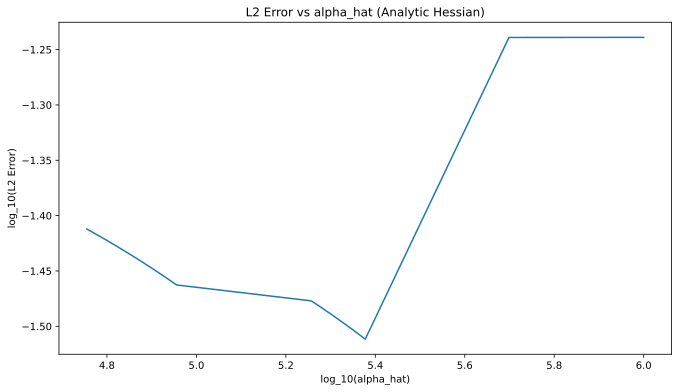

In [ ]:
plt.plot(np.log10(alpha_passes), np.log10(L2_errors))
plt.xlabel('log_10(alpha_hat)')
plt.ylabel('log_10(L2 Error)')
plt.title('L2 Error vs alpha_hat (Analytic Hessian)')
plt.show()

# Show the Best Solution

In [ ]:
# For fun lets find these mins

# Find index of min value in my L2 and H1 lists
min_L2 = min(L2_errors)
index_min_L2 = L2_errors.index(min_L2)

# Pull the corresponding alpha hat value
alpha_min_L2 = alpha_passes[index_min_L2]

print("Alpha value for min L2 error is", alpha_min_L2)
print("The corresponding min L2 error is", min_L2)


Alpha value for min L2 error is 238511.89347805938
The corresponding min L2 error is 0.030789524175254858


In [ ]:
print('The best solution is for alpha_tilda = ', saved_sols[index_min_L2][0])
best_sol = saved_sols[index_min_L2][1]
best_sol_x = saved_sols[index_min_L2][2]

The best solution is for alpha_tilda =  238511.89347805938


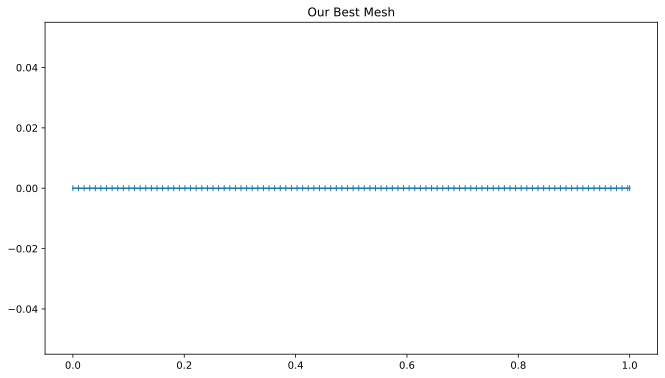

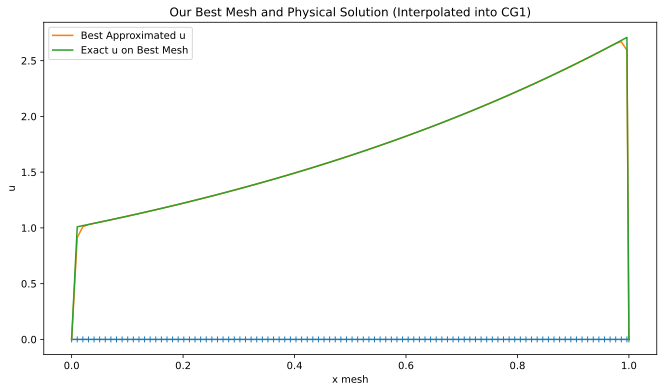

In [ ]:
# Plot the best solution



# Reset exact solution (I think this is a waste)
top = (1 - exp(1 - 1/eps))*exp(-best_sol_x/eps) + (exp(1) - exp(-1/eps))*exp((best_sol_x-1)/eps)
bottom = (eps**2 - 1) * ( 1 - exp(-2/eps) )
sub = exp(best_sol_x)/(eps**2 - 1)
u_exact_best = top/bottom - sub





# Plot
plt.plot(best_sol_x.dat.data[perm_x], np.zeros_like(x.dat.data[perm_x]), marker = "|")
plt.title("Our Best Mesh")
plt.show()
print()
print()

plt.plot(best_sol_x.dat.data[perm_x], np.zeros_like(x.dat.data[perm_x]), marker = "|")
plt.plot(best_sol_x.dat.data[perm_x], Function(V).interpolate(best_sol).dat.data[perm_x], label = "Best Approximated u")
plt.plot(best_sol_x.dat.data[perm_x], Function(V).interpolate(u_exact_best).dat.data[perm_x], label = "Exact u on Best Mesh")
plt.title("Our Best Mesh and Physical Solution (Interpolated into CG1)")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()
print()
print()